# Detecting Text in Signs

In [2]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

Firstly, read the image using OpenCV2 and plot it using Matplotlib

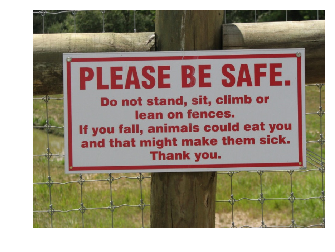

In [3]:
imgName = 'imgs/img_883.jpg'
regularImg = cv2.imread(imgName)
plt.imshow(cv2.cvtColor(regularImg, cv2.COLOR_BGR2RGB), cmap='gray')
plt.axis('off');

Changing it to grayscale and blurring it a bit

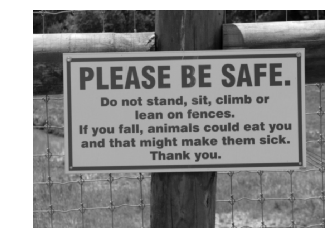

In [4]:
grayImg = cv2.cvtColor(regularImg, cv2.COLOR_BGR2GRAY);
blurredImg = applyBlurToImg(grayImg)
plt.imshow(blurredImg, cmap='gray')
plt.axis('off');

Then, binarizing the image

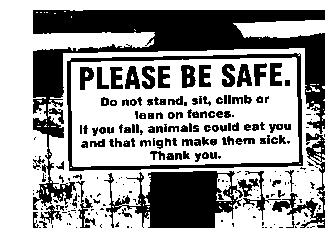

In [5]:
binaryImg = getBinaryImg(blurredImg)
plt.imshow(binaryImg, cmap='gray')
plt.axis('off');

Since this image has a plate with several edges, it's easy to detect them. There is the bounding box

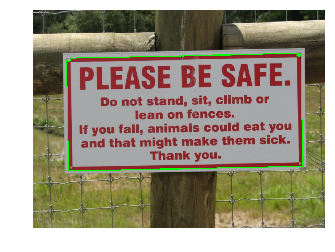

In [6]:
bestContour = getBestContour(binaryImg)
regularImgWithDetection = applyDetectionToImg(regularImg, bestContour)
plt.imshow(cv2.cvtColor(regularImgWithDetection, cv2.COLOR_BGR2RGB), cmap='gray')
plt.axis('off');

Now there is the crop, and we are done with this image

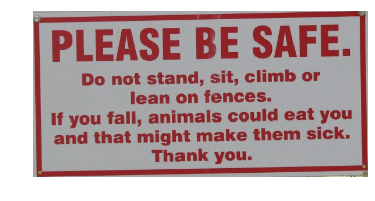

In [7]:
croppedImg = cropImg(regularImg, bestContour)
plt.imshow(cv2.cvtColor(croppedImg, cv2.COLOR_BGR2RGB), cmap='gray')
plt.axis('off');

Now, for a slightly different scenario, let's use another image as input

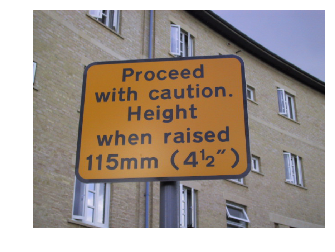

In [8]:
imgName = 'imgs/117_icdar13.png'
regularImg = cv2.imread(imgName)
plt.imshow(cv2.cvtColor(regularImg, cv2.COLOR_BGR2RGB), cmap='gray')
plt.axis('off');

Using the same methods and parameters as above

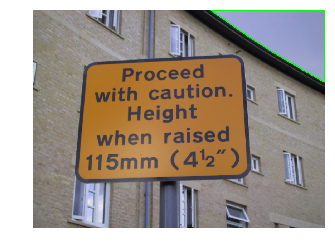

In [9]:
grayImg = cv2.cvtColor(regularImg, cv2.COLOR_BGR2GRAY);
blurredImg = applyBlurToImg(grayImg)
binaryImg = getBinaryImg(blurredImg)
bestContour = getBestContour(binaryImg)
regularImgWithDetection = applyDetectionToImg(regularImg, bestContour)

plt.imshow(cv2.cvtColor(regularImgWithDetection, cv2.COLOR_BGR2RGB), cmap='gray')
plt.axis('off');

What went wrong? Let's check the binarized image

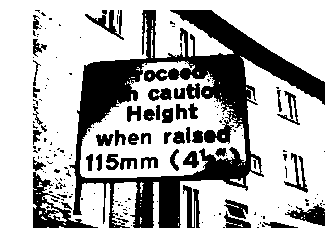

In [10]:
plt.imshow(binaryImg, cmap='gray')
plt.axis('off');

The top-right edge of the plate got mixed up with the buildings roof. That is because the region between those two things is a bit darker than our threshold for binarization. So, let's try a lower alpha value

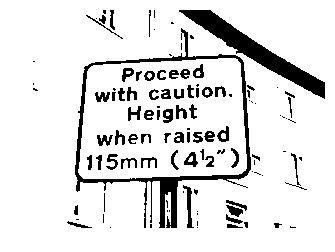

In [11]:
binaryImg = getBinaryImg(blurredImg, alpha = 0.75)
plt.imshow(binaryImg, cmap='gray')
plt.axis('off');

Now we can see the plate's edges clearly. Continuing...

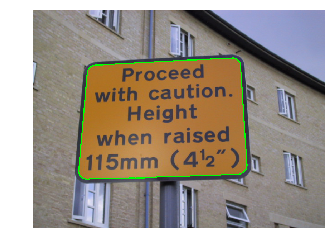

In [12]:
bestContour = getBestContour(binaryImg)
regularImgWithDetection = applyDetectionToImg(regularImg, bestContour)
plt.imshow(cv2.cvtColor(regularImgWithDetection, cv2.COLOR_BGR2RGB), cmap='gray')
plt.axis('off');

And cropping...

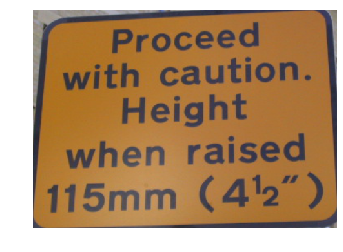

In [13]:
croppedImg = cropImg(regularImg, bestContour)
plt.imshow(cv2.cvtColor(croppedImg, cv2.COLOR_BGR2RGB), cmap='gray')
plt.axis('off');

Now, a harder case to solve

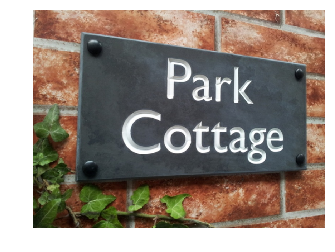

In [14]:
imgName = 'imgs/img_1020.jpg'
regularImg = cv2.imread(imgName)
plt.imshow(cv2.cvtColor(regularImg, cv2.COLOR_BGR2RGB), cmap='gray')
plt.axis('off');

When coloured, it seems like another easy case, but when turning it into greyscale, the colours of the plate and the wall look too similar

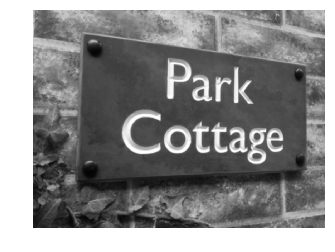

In [15]:
grayImg = cv2.cvtColor(regularImg, cv2.COLOR_BGR2GRAY);
blurredImg = applyBlurToImg(grayImg)
plt.imshow(cv2.cvtColor(blurredImg, cv2.COLOR_BGR2RGB), cmap='gray')
plt.axis('off');

Let's try different values of alpha for binarization and see how it goes

The alpha values will increase by 0.1 from 0.6 to 1.4

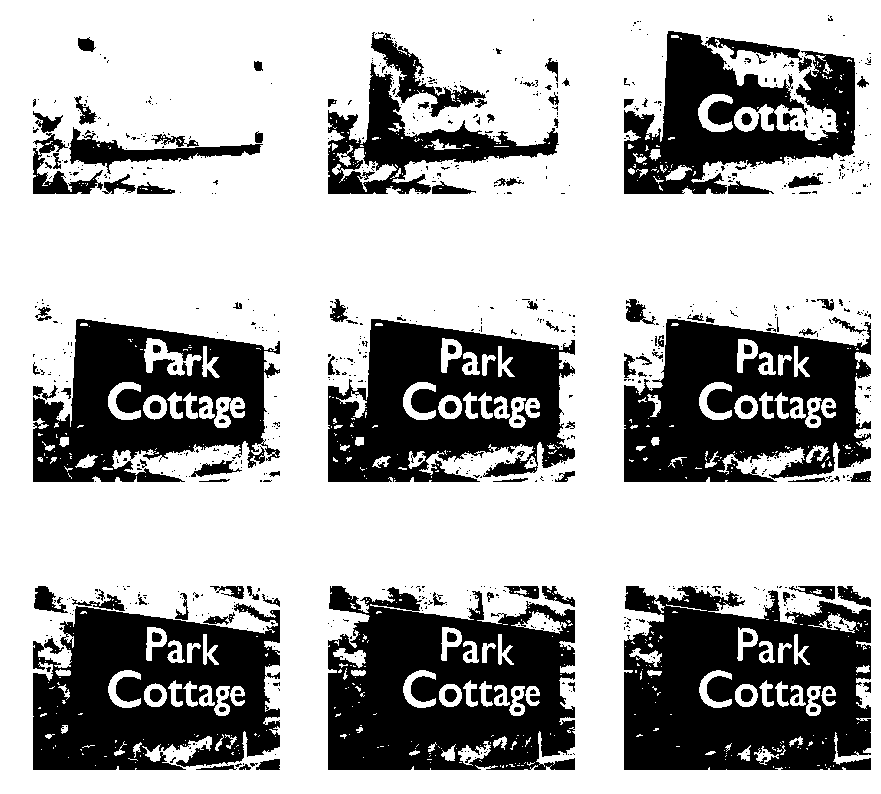

In [16]:
h = w = 10
fig = plt.figure(figsize=(15, 15))
rows = cols = 3
for i in range(1, cols*rows +1):
    img = getBinaryImg(blurredImg, alpha=0.5 + 0.10*i)
    fig.add_subplot(rows, cols, i)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.show()

None of these binarizations seem friendly. That means, no matter what value of alpha we use, there will be no scenario in which the background wall will be separated from the plate.

But looking back at the coloured image, we can clearly see that the plate has a dark grey colour, the wall is reddish brown and there are some green leaves too. So what if we try to proccess it separatedly for each colour channel?

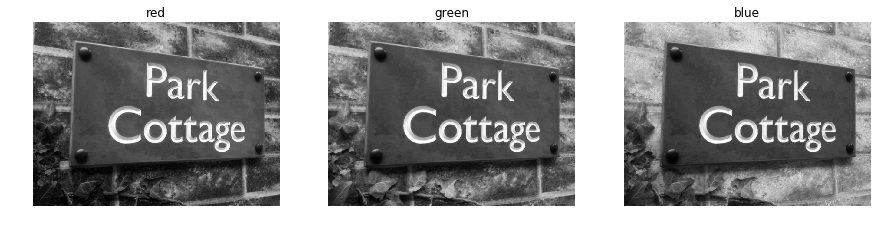

In [17]:
fig = plt.figure(figsize=(15, 15))
rows = 1
colours = ['red', 'green', 'blue']
for i in range(1, cols*rows +1):
    singleChannelImg = regularImg[:,:,i-1]
    fig.add_subplot(rows, cols, i)
    plt.imshow(singleChannelImg, cmap='gray')
    plt.title(colours[i-1])
    plt.axis('off')
plt.show()

The wall on the blue channel is way lighter than on the red and green. So, the binarization there will be easier. We just need to find an alpha that fits our needs

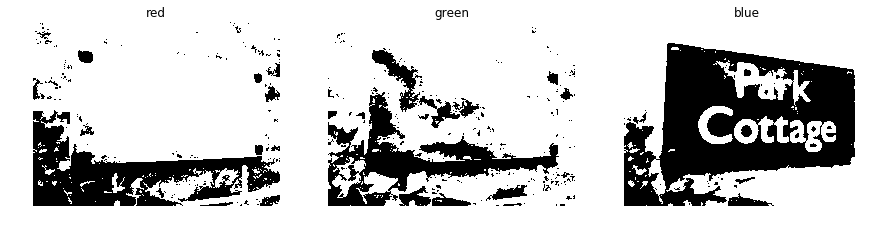

In [18]:
singleChannelImgs = [regularImg[:,:,0], regularImg[:,:,1], regularImg[:,:,2]]
blurredImgs = [applyBlurToImg(img) for img in singleChannelImgs]
binaryImgs = [getBinaryImg(img, alpha=0.7) for img in blurredImgs]

fig = plt.figure(figsize=(15, 15))
for i in range(1, cols*rows +1):
    binaryImg = binaryImgs[i-1]
    fig.add_subplot(rows, cols, i)
    plt.imshow(binaryImg, cmap='gray')
    plt.title(colours[i-1])
    plt.axis('off')
plt.show()

Trying to get the best contour now

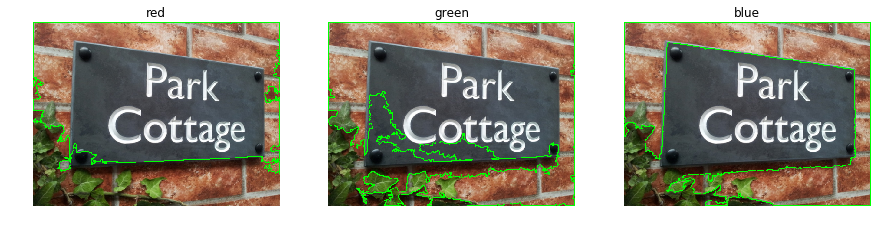

In [19]:
bestContours = [getBestContour(img, maxVertex=100) for img in binaryImgs]
fig = plt.figure(figsize=(15, 15))
for i in range(1, cols*rows +1):
    regularImgWithDetection = applyDetectionToImg(regularImg, bestContours[i-1])
    fig.add_subplot(rows, cols, i)
    plt.imshow(cv2.cvtColor(regularImgWithDetection, cv2.COLOR_BGR2RGB), cmap='gray')
    plt.title(colours[i-1])
    plt.axis('off')
plt.show()

This approach didn't show great improvement, since the plate contour is not being captured. If it were, we could set the maximum amount of vertices to 4 (or another close value), so the largest contoured area selected would not be the wall on the background

In [1]:
def cropImg(img, contour):
    maxX = maxY = 0
    minX = minY = img.shape[0]
    for c in contour:
        c = c[0]
        if c[0] > maxX:
            maxX = c[0]
        elif c[0] < minX:
            minX = c[0]

        if c[1] > maxY:
            maxY = c[1]
        elif c[1] < minY:
            minY = c[1]

    regularImg = cv2.imread(imgName)
    crop_img = regularImg[minY:maxY, minX:maxX]
    return crop_img

def applyBlurToImg(img):
    return cv2.GaussianBlur(img, (5, 5), 0)

def getBinaryImg(img, alpha = 1.0):
    mean = np.mean(img)
    _, binaryImg = cv2.threshold(img, mean*alpha, 255, 0)
    return binaryImg

def getBestContour(img, minVertex=0, maxVertex=15):
    contours, hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    maxArea = 0
    
    for c in contours:
        perimeter = cv2.arcLength(c, True)
        area = cv2.contourArea(c)
        approxPolygon = cv2.approxPolyDP(c, 0.005 * perimeter, True)
#         (x, y, w, h) = cv2.boundingRect(approxPolygon)
        if len(approxPolygon) > minVertex and len(approxPolygon) < maxVertex and area > maxArea:
            largestC = c
            maxArea = area
    return largestC

def applyDetectionToImg(regularImgAux, bestContour):
    regularImg = np.copy(regularImgAux)
    cv2.drawContours(regularImg, [bestContour], -1, (0, 255, 0), 2)
    return regularImg